# Data Visualization Project
Student: Lucas Gabriel Mocellin Teixeira

### Introduction

In [1]:
import networkx as nx
# as we will use a real dataset
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random

In [16]:
g = nx.read_gml('data/dolphins.gml')

In [17]:
pos = nx.spring_layout(g)

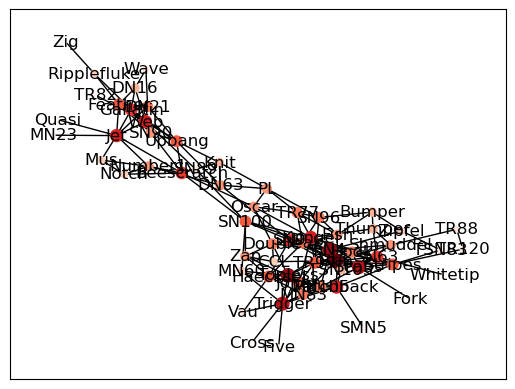

In [18]:
deg_cen_g = nx.degree_centrality(g)
deg_cen_list = []

for i in deg_cen_g:
    deg_cen_list.append(deg_cen_g[i])
    
size_list = [500*deg_cen_g[i] for i in g.nodes()]

nx.draw_networkx(g, pos, node_size = size_list, node_color = deg_cen_list, cmap = plt.cm.Reds)

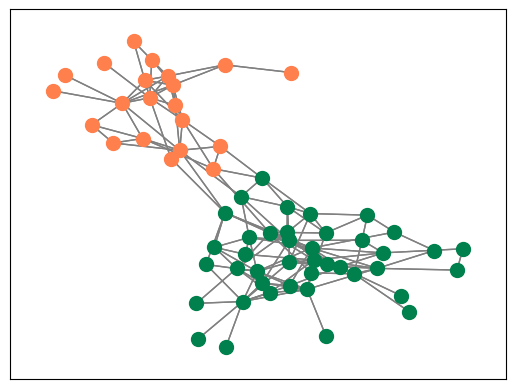

In [28]:
import itertools
comp = nx.community.girvan_newman(g)
posi_gn = nx.spring_layout(g)

k = 2  # number of communities
for _ in range(k-1):
    comms = next(comp)
    
colors = np.linspace(0, 1, k)
color_list = [plt.cm.colors.to_hex((color, 0.5, 0.3)) for color in colors]

deg_cen_g = nx.degree_centrality(g)
deg_cen_list = []

for i in deg_cen_g:
    deg_cen_list.append(deg_cen_g[i])
    
size_list = [500*deg_cen_g[i] for i in g.nodes()]

i=0
for nodes, c in zip(comms, color_list):
    nx.draw_networkx_nodes(g, posi_gn, nodelist=nodes, node_color=[c], node_size = 100)
    nx.draw_networkx_edges(g, posi_gn, edge_color = "gray")
    i+=1

In [2]:
adj_matrix = np.loadtxt('data/monkeys.txt', dtype=int)

# create a graph object from the adjacency matrix
G = nx.from_numpy_matrix(adj_matrix)

# print some basic information about the graph
print(nx.info(G))

Graph with 20 nodes and 181 edges


C:\Users\lucas\AppData\Local\Temp\ipykernel_12176\2758328610.py:7: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [3]:
pos = nx.spring_layout(G)

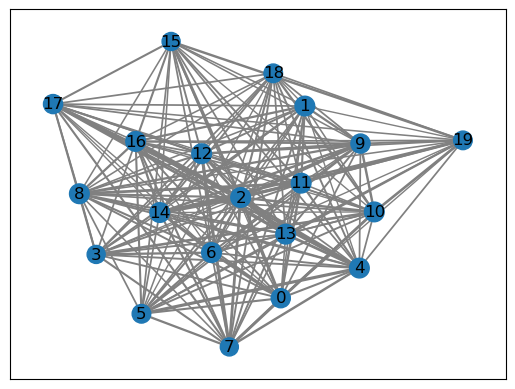

In [6]:
deg_cen_g = nx.degree_centrality(G)
deg_cen_list = []

for i in deg_cen_g:
    deg_cen_list.append(deg_cen_g[i])
    
size_list = [200*deg_cen_g[i] for i in G.nodes()]

edge_weights = adj_matrix.flatten()
edge_weights = edge_weights[edge_weights.nonzero()]
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())
edge_widths = 1 + 2* edge_weights

nx.draw_networkx(G, pos, node_size = size_list, width=edge_widths, edge_color = "gray")

In [68]:
size_list

[189.4736842105263,
 200.0,
 200.0,
 168.42105263157893,
 200.0,
 178.9473684210526,
 200.0,
 168.42105263157893,
 200.0,
 189.4736842105263,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 168.42105263157893,
 200.0,
 189.4736842105263,
 178.9473684210526,
 178.9473684210526]